In [150]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.cm import get_cmap
import seaborn as sns
import geopandas as gpd
from pathlib import Path
import pycountry
from copy import deepcopy

from pathlib import Path

idx = pd.IndexSlice

In [151]:
from region_grouper import coarse_regions

data_path = Path.cwd().parent.parent.parent / "cluster_data"
regions = gpd.read_file(data_path / "resources" / "regions_onshore_elec_s_72.geojson")
regions = regions.set_index("name")
regions["name"] = regions.index

def dict_list(dict):
    aslist = list()

    for value in dict.values():
        aslist += value

    return aslist

def make_region_mapper():

    result = deepcopy(coarse_regions)
    covered = dict_list(result)

    for bus in regions.index:

        if bus in covered:
            continue

        result[pycountry.countries.get(alpha_2=bus[:2]).name] = [bus]

    return result

mapper = make_region_mapper()
reverse_mapper = dict()

for key, values in mapper.items():
    for value in values:
        reverse_mapper[value] = key

regions["region"] = regions["name"].apply(lambda entry: reverse_mapper[entry])
regions

,geometry,name,region
name,,,
AL1 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...",AL1 0,Albania
AT1 0,"POLYGON ((13.86068 46.51525, 13.67026 46.51871...",AT1 0,Austria
BA1 0,"POLYGON ((17.82716 42.85312, 17.81176 42.90986...",BA1 0,Bosnia and Herzegovina
BE1 0,"POLYGON ((4.68192 50.08392, 4.67292 50.01638, ...",BE1 0,Belgium
BG1 0,"POLYGON ((23.94989 41.43758, 23.89480 41.46434...",BG1 0,Bulgaria
...,...,...,...
RS1 0,"POLYGON ((20.75050 41.90680, 20.72331 41.86662...",RS1 0,Serbia
SE2 0,"MULTIPOLYGON (((12.97918 55.40327, 12.83277 55...",SE2 0,Sweden
SE2 1,"MULTIPOLYGON (((17.49916 61.72383, 17.45725 61...",SE2 1,Sweden


In [152]:
root = Path.cwd().parent.parent.parent / "cluster_data"

In [153]:
carrier_mapper = {
    "elec": "geothermal heat elec",
    "chp": "geothermal heat chp elec",
    "dh": "geothermal heat dh",
}

def get_data(mode, op, process=True):

    if mode == "chp" or mode == "dh":
        df = pd.read_csv(
            root / f"{mode}_data" / 
            f"csvs_{op}" / 
            "nodal_capacities.csv", 
            index_col=[0,1,2], 
            header=[4,5,6]
            )
    elif mode == "elec":
        df = pd.read_csv(root / f"{mode}_data" / "csvs" / "nodal_capacities.csv", index_col=[0,1,2], header=[4,5,6])
    
    if process:

        df.index = df.index.droplevel(0)
        df = df.loc[idx[:, carrier_mapper[mode]], :]

        df.index = df.index.get_level_values(0)
        df.columns = df.columns.get_level_values(0)

    return df

# group df index by dictionary with list
def group_df(df, mapper):
    
        result = pd.DataFrame(columns=df.columns)
    
        for key, value in mapper.items():
    
            result.loc[key] = df.loc[value, :].sum(axis=0)
    
        return pd.DataFrame(result)

df = get_data("chp", "flex")
grouped = group_df(df, mapper)
grouped.columns = grouped.columns.astype(int)


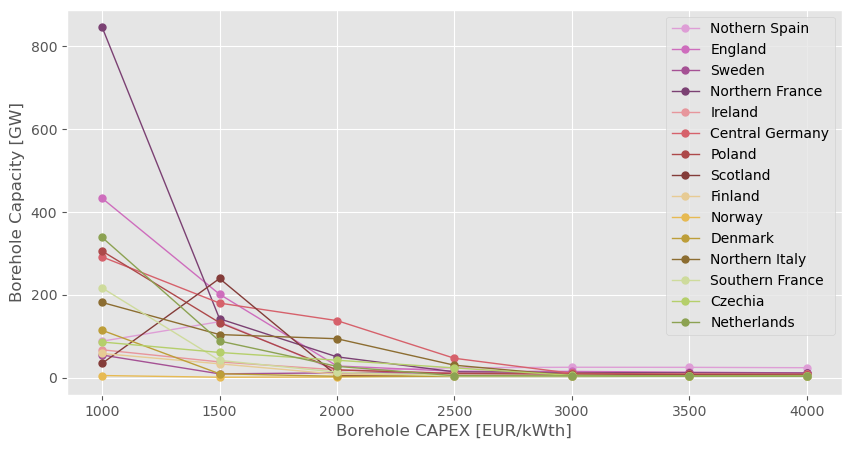

In [198]:
n_show = 15

cmap = get_cmap("tab20b")
colors = cmap.colors[::-1]
plot = grouped.sort_values(by=4000, ascending=False).iloc[:n_show, :].mul(1e-3)

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_prop_cycle(color=colors)
plot.T.plot(ax=ax, marker="o", linewidth=1, markersize=5)

ax.set_ylabel("Borehole Capacity [GW]")
ax.set_xlabel("Borehole CAPEX [EUR/kWth]")

plt.show()

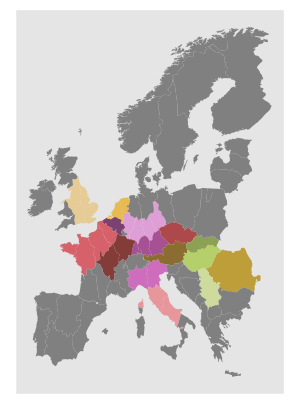

In [155]:
fig, ax = plt.subplots(figsize=(10, 5))

for reg, color in zip(plot.index, colors):
    regions.loc[regions["region"] == reg].plot(ax=ax, color=color)

regions.loc[~regions["region"].isin(plot.index)].plot(ax=ax, color="gray")

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [179]:
def get_displaced_capacity(df, col):

    carriers = df.index.get_level_values(2).unique()
    others = [c for c in carriers if not "geothermal" in str(c)] 
    
    df = deepcopy(df)
    df = df.loc[idx[:, :, others], :]

    if not isinstance(col, pd.Series):
        col = df.loc[:, col]

    df = pd.DataFrame(
        np.subtract(df.values, col.values[:,None]),
        index=df.index,
        columns=df.columns,
        ).mul(1e-3)

    return df


df = get_data("chp", "flex", process=False)

col = df.columns[-1]
diff = get_displaced_capacity(df, col)


In [180]:
import yaml
with open(Path.cwd().parent / "config" / "config.yaml", "r") as f:
    tech_colors = yaml.safe_load(f)["plotting"]["tech_colors"]

Index(['generators', 'stores', 'lines', 'links', 'progress', 'storage_units'], dtype='object')
generators


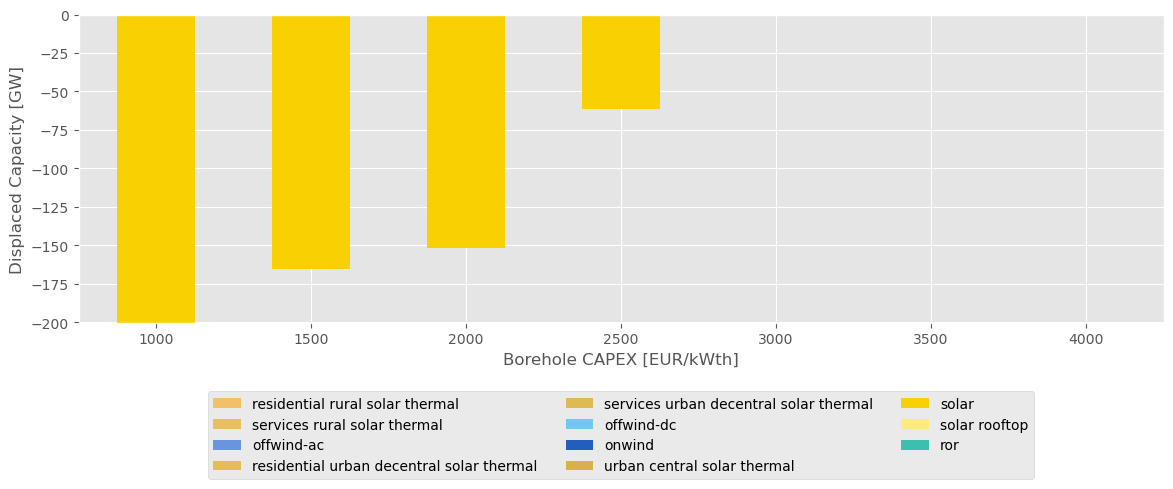

stores


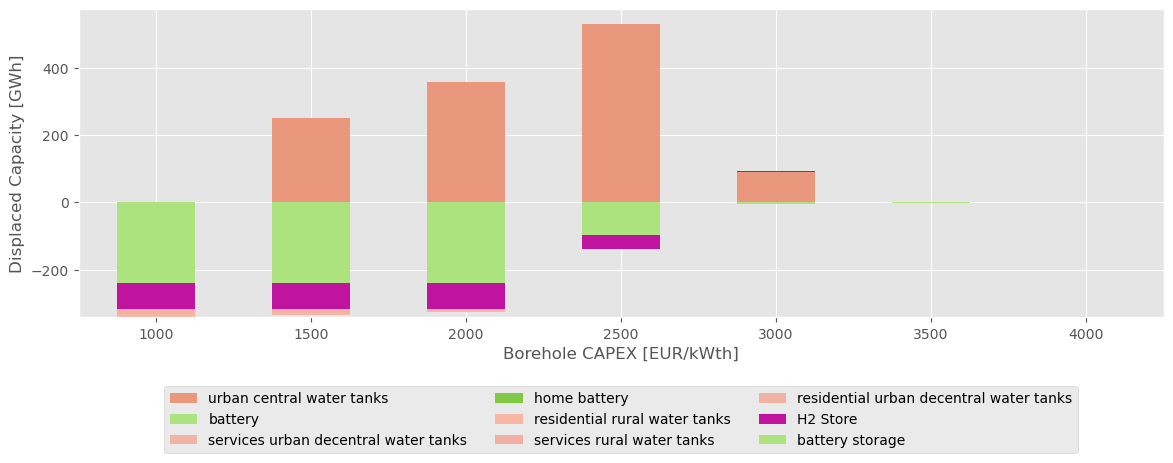

lines
links


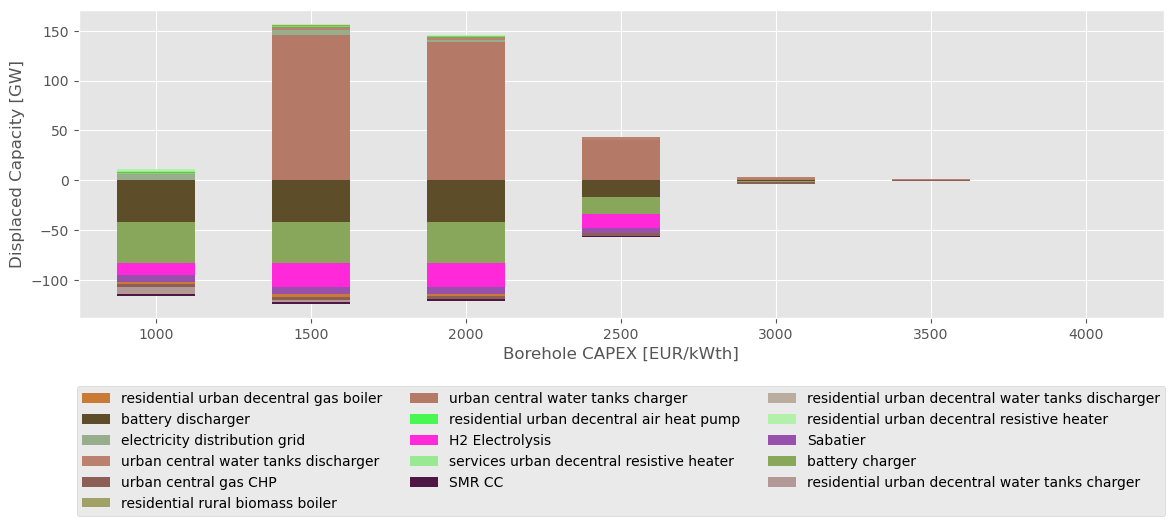

progress
storage_units


In [207]:
from matplotlib.patches import Patch



plot_regions = "Northern Italy"
n_show_carriers = 16
units = {
    "generators": "GW",
    "links": "GW",
    "stores": "GWh",
    }

print(diff.index.get_level_values(0).unique())


for c in diff.index.get_level_values(0).unique():

    print(c)
    if c in ["lines", "progress", "storage_units"]:
        continue

    ss = diff.loc[idx[c,:,:], :]
    ss.index = ss.index.droplevel(0)

    ss = ss.loc[idx[mapper[plot_regions], :], :].groupby(level=1).sum()
    ss.columns = ss.columns.get_level_values(0).astype(int)

    ss_negative = pd.DataFrame(np.minimum(ss.values, 0), index=ss.index, columns=ss.columns)
    ss_positive = pd.DataFrame(np.maximum(ss.values, 0), index=ss.index, columns=ss.columns)

    index = ss_negative.abs().sort_values(by=1500, ascending=False).index[:n_show_carriers//2]
    ss_negative = ss_negative.loc[index, :]

    index = ss_positive.sort_values(by=1500, ascending=False).index[:n_show_carriers//2]
    ss_positive = ss_positive.loc[index, :]

    fig, ax = plt.subplots(figsize=(14, 4))

    ss_negative.T.plot(kind="bar",
        stacked=True,
        color=[tech_colors[c] for c in ss_negative.index],
        legend=False,
        ax=ax,
        )
    ss_positive.T.plot(kind="bar",
        stacked=True,
        color=[tech_colors[c] for c in ss_positive.index],
        legend=False,
        ax=ax,
        )

    legend_elements = [
        Patch(facecolor=tech_colors[carrier], label=carrier)
        for carrier in set(ss_negative.index.tolist() + ss_positive.index.tolist())
    ]
    ax.legend(
        handles=legend_elements,
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.2),
        fancybox=True,
        shadow=False,
        ncol=3,
        )

    # rotate xticklabels
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    ax.set_xlabel("Borehole CAPEX [EUR/kWth]")
    ax.set_ylabel(f"Displaced Capacity [{units[c]}]")

    plt.show()

In [202]:
diff.loc[idx["links",:,:],:]

egs_capex                                            1000          1500  \
egs_mode                                              chp           chp   
egs_op                                               flex          flex   
links NaN     DC                             0.000000e+00  0.000000e+00   
      AL1 0   BEV charger                    0.000000e+00  0.000000e+00   
      AT1 0   BEV charger                    0.000000e+00  0.000000e+00   
      BA1 0   BEV charger                    0.000000e+00  0.000000e+00   
      BE1 0   BEV charger                    0.000000e+00  0.000000e+00   
...                                                   ...           ...   
      gas for gas for industry               9.790685e-07  1.738270e-06   
              gas for industry CC           -9.592210e-07 -1.413740e-06   
      process process emissions              7.453422e-08  1.160263e-07   
      solid   solid biomass for industry     7.540116e-08  3.273745e-07   
              solid biomass for industry CC -1.131055e-08 -7.757088e-08   

egs_capex                                            2000          2500  \
egs_mode                                              chp           chp   
egs_op                                               flex          flex   
links NaN     DC                             0.000000e+00  0.000000e+00   
      AL1 0   BEV charger                    0.000000e+00  0.000000e+00   
      AT1 0   BEV charger                    0.000000e+00  0.000000e+00   
      BA1 0   BEV charger                    0.000000e+00  0.000000e+00   
      BE1 0   BEV charger                    0.000000e+00  0.000000e+00   
...                                                   ...           ...   
      gas for gas for industry               1.516876e-06  1.187075e-06   
              gas for industry CC           -1.624408e-06 -8.602298e-07   
      process process emissions              5.460116e-08  9.869053e-08   
      solid   solid biomass for industry     2.823086e-07  3.373018e-07   
              solid biomass for industry CC -2.796464e-07 -1.356398e-07   

egs_capex                                            3000          3500 4000  
egs_mode                                              chp           chp  chp  
egs_op                                               flex          flex flex  
links NaN     DC                             0.000000e+00  0.000000e+00  0.0  
      AL1 0   BEV charger                    0.000000e+00  0.000000e+00  0.0  
      AT1 0   BEV charger                    0.000000e+00  0.000000e+00  0.0  
      BA1 0   BEV charger                    0.000000e+00  0.000000e+00  0.0  
      BE1 0   BEV charger                    0.000000e+00  0.000000e+00  0.0  
...                                                   ...           ...  ...  
      gas for gas for industry               4.931499e-07  1.863939e-07  0.0  
              gas for industry CC           -3.091495e-07 -1.824393e-07  0.0  
      process process emissions              1.400126e-08  2.398763e-09  0.0  
      solid   solid biomass for industry     2.008797e-07  4.176739e-08  0.0  
              solid biomass for industry CC -9.416782e-08 -4.441182e-08  0.0  

[3536 rows x 7 columns]